# Classification des panneaux de signalisation

Détection et reconnaissance de la signalisation routière, notebook 1/2

<hr>

- <a href='#1'>1. Importation des données et création des datasets</a>
- <a href='#2'>2. Préparation des variables en vue d'un traitement sous Keras</a>
- <a href='#3'>3. Entrainement d'un CNN de reconnaissance des panneaux de signalisation</a>

<hr>

In [1]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import pandas as pd
import time
import copy

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from keras.layers import Conv2D, experimental, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical

## <a id='1'>1. Préparation des données</a>

### Création des jeux de données

#### Création du jeu de données d'entraînement 

In [2]:
train_set = []

for i in range(43):
    tmp = [cv2.imread(file, 0) for file in glob.glob(f"../Data_Signs/Train/{i}/*.png")] 
    train_set.append(tmp)
    # glob.glob : on peut aussi utiliser os.listdir

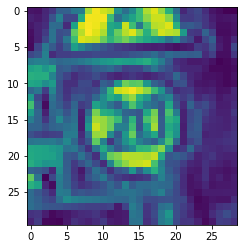

In [3]:
plt.imshow(train_set[0][0]) #test

In [4]:
X_train = []
for i in range(len(train_set)):
    for j in range(len(train_set[i])):
        train_set[i][j] = cv2.resize(train_set[i][j], (50,50))
        X_train.append(train_set[i][j])

In [5]:
X_train = np.asarray(X_train, dtype=list)
print(X_train.shape)

(39209, 50, 50)


In [6]:
# target
y_train = np.full((len(train_set[0]),1),0)

for i in range(1,len(train_set)):
    y_train  = np.concatenate( 
        (y_train, 
         np.full((len(train_set[i]),1),i)),
        axis=0)
y_train.reshape(len(y_train),-1)

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [42],
       [42],
       [42]])

In [7]:
print(y_train.shape)

(39209, 1)


In [8]:
labels, occurrence = np.unique(y_train, return_counts=True)
print(len(labels), "différents labels :", labels)
print("occurrences de chacun :",occurrence)

43 différents labels : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
occurrences de chacun : [ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160
  780  630  420 1110 1200  210  360  330  390  510  270 1500  600  240
  540  270  450  780  240  689  420 1200  390  210 2070  300  360  240
  240]


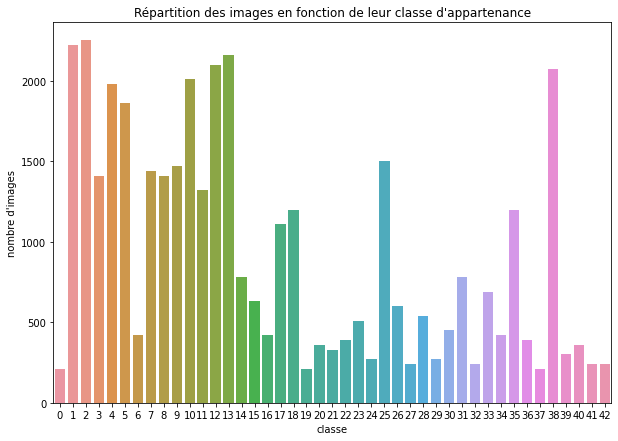

In [22]:
plt.figure(figsize=(10,7))
sns.barplot(x=labels, y=occurrence)
plt.xlabel('classe')
plt.ylabel('nombre d\'images')
plt.title('Répartition des images en fonction de leur classe d\'appartenance')
plt.savefig('images/count.png')

In [10]:
# on "mélange" les données

index = np.random.permutation([i for i in range(len(y_train))])
X_train = X_train[index]
y_train = y_train[index]

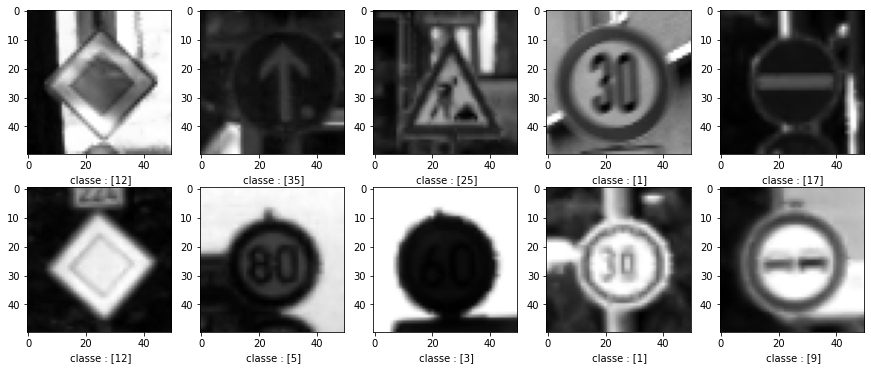

In [11]:
# impression pour vérification

plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow( np.uint8(X_train[i]), cmap='gray')
    plt.xlabel(" classe : {}".format(y_train[i]))
plt.show()


#### Création du jeu de données de test

In [12]:
test_set = [cv2.imread(file, 0) for file in glob.glob(f"../Data_Signs/Test/*.png")]
for i in range(len(test_set)):
    test_set[i] = cv2.resize(test_set[i], (50,50))

In [13]:
X_test = np.asarray(test_set, dtype=list)
print(X_test.shape)

(12630, 50, 50)


In [14]:
classes_test = pd.read_csv("../Data_Signs/Test.csv", sep=",")
y_test = classes_test['ClassId'].values

## <a id='2'>2. Préparation des variables</a>

#### Standardisation - Redimensionnement des features

In [15]:
X_train = X_train.astype('float') / 255
X_test = X_test.astype('float') / 255

In [16]:
X_train = X_train.reshape(len(X_train),50,50,1)
X_test = X_test.reshape(len(X_test),50,50,1)

In [17]:
print(X_train.shape)
print(X_test.shape)

(39209, 50, 50, 1)
(12630, 50, 50, 1)


#### Encodage de la target

In [18]:
Y_train = to_categorical(y_train, num_classes=43)
Y_test = to_categorical(y_test, num_classes=43)

In [19]:
print(Y_train.shape)
print(Y_test.shape)

(39209, 43)
(12630, 43)


## <a id='3'>3. Réseau neuronal convolutif (CNN)  pour la reconnaissance des panneaux</a>

### Création du modèle

In [ ]:
model1 = models.Sequential()

model1.add(Conv2D(64, 3, padding="same", activation='relu', input_shape=(50,50,1)))
model1.add(Conv2D(64, 3, padding="same", activation='relu'))
model1.add(MaxPooling2D(2))
model1.add(Conv2D(128, 3, padding="same", activation='relu'))
model1.add(Conv2D(128, 3, padding="same", activation='relu'))
model1.add(MaxPooling2D(2))
model1.add(Flatten())
model1.add(Dense(64, activation="relu"))
model1.add(Dropout(0.25))
model1.add(Dense(52, activation="relu"))
model1.add(Dropout(0.25))
model1.add(Dense(43, activation='softmax'))


In [23]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 50, 50, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)            

#### Entraînement de vérification de la cohérence du modèle avec des hyperparamètres aléatoire

In [33]:
model1.compile(optimizer=optimizers.Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
Y_train.shape

(39209, 43)

In [35]:
model1.fit(X_train, Y_train, epochs=12, batch_size=12, validation_split=0.2)

Epoch 1/12
2614/2614 [==============================] - 767s 293ms/step - loss: 0.4338 - accuracy: 0.8613 - val_loss: 0.1810 - val_accuracy: 0.9487
Epoch 2/12
2614/2614 [==============================] - 754s 289ms/step - loss: 0.3984 - accuracy: 0.8737 - val_loss: 0.1961 - val_accuracy: 0.9343
Epoch 3/12
2614/2614 [==============================] - 753s 288ms/step - loss: 0.3896 - accuracy: 0.8768 - val_loss: 0.1543 - val_accuracy: 0.9547
Epoch 4/12
2614/2614 [==============================] - 757s 290ms/step - loss: 0.3436 - accuracy: 0.8902 - val_loss: 0.1587 - val_accuracy: 0.9501
Epoch 5/12
2614/2614 [==============================] - 758s 290ms/step - loss: 0.3311 - accuracy: 0.8954 - val_loss: 0.1674 - val_accuracy: 0.9528
Epoch 6/12
2614/2614 [==============================] - 754s 288ms/step - loss: 0.3167 - accuracy: 0.8988 - val_loss: 0.1386 - val_accuracy: 0.9589
Epoch 7/12
2614/2614 [==============================] - 757s 290ms/step - loss: 0.2742 - accuracy: 0.9129 - val_

In [ ]:
model1.save('model_recog_93')

In [26]:
model_2=models.load_model('TransferLearning_Tensorflow/model_recog_93')

In [36]:
model_2.compile(optimizer=optimizers.Adamax(learning_rate = 0.0001, beta_1=0.98, beta_2=0.988), loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model_2.fit(X_train, Y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
3137/3137 [==============================] - 797s 254ms/step - loss: 0.1426 - accuracy: 0.9561 - val_loss: 0.0478 - val_accuracy: 0.9809
Epoch 2/5
3137/3137 [==============================] - 796s 254ms/step - loss: 0.1431 - accuracy: 0.9545 - val_loss: 0.0480 - val_accuracy: 0.9810
Epoch 3/5
3137/3137 [==============================] - 788s 251ms/step - loss: 0.1418 - accuracy: 0.9548 - val_loss: 0.0471 - val_accuracy: 0.9809
Epoch 4/5
3137/3137 [==============================] - 794s 253ms/step - loss: 0.1494 - accuracy: 0.9533 - val_loss: 0.0476 - val_accuracy: 0.9806
Epoch 5/5
3137/3137 [==============================] - 793s 253ms/step - loss: 0.1396 - accuracy: 0.9551 - val_loss: 0.0472 - val_accuracy: 0.9810


In [38]:
model_2.save('model_recog_96')

INFO:tensorflow:Assets written to: model_recog_96\assets


In [39]:
Y_pred1 = model_2.predict(X_test)

In [40]:
y_pred1 = [np.where(Y_pred1[i] == np.max(Y_pred1[i]))[0] for i in range(len(Y_pred1))]

In [41]:
cmat1 = confusion_matrix(y_test, y_pred1)
accur1 = accuracy_score(y_test, y_pred1)
print("accuracy score :", accur1.round(3)*100, "%")

accuracy score : 94.6 %


Text(0, 0.5, 'valeurs calculées')

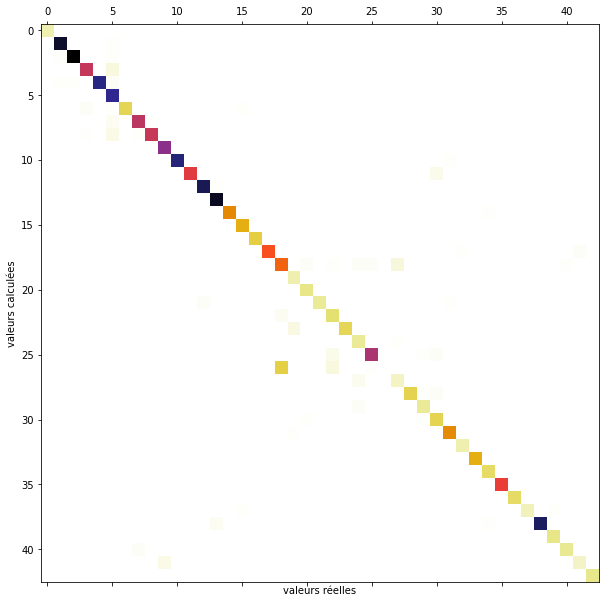

In [42]:
plt.figure(figsize=(10,10))
plt.matshow(cmat1,cmap=plt.cm.CMRmap_r, fignum=1)
plt.xlabel("valeurs réelles")
plt.ylabel("valeurs calculées")

__________________________________